# Suspensión activa

## Configuración física

El diseño de un sistema de suspensión automotriz es un problema de control interesante y desafiante. Cuando se diseña el sistema de suspensión, se usa un modelo de 1/4 (una de las cuatro ruedas) para simplificar el problema a un sistema de resorte-amortiguador múltiple 1-D. A continuación se muestra un diagrama de este sistema. 

```{figure} .\susp1.png
:width: 400px
:align: center
:name: susp

Suspensión activa
```

Este modelo es para un sistema de suspensión activa donde se incluye un actuador que puede generar la fuerza de control $U$ para controlar el movimiento de la carrocería del autobús.




Parámetros del sistema

(M1) 1/4 masa del cuerpo del autobús 2500 kg

(M2) masa de suspensión 320 kg

(K1) constante de resorte del sistema de suspensión 80,000 N/m

(K2) constante de resorte de rueda y neumático 500,000 N/m

(b1) constante de amortiguamiento del sistema de suspensión 350 N.s/m

(b2) constante de amortiguamiento de rueda y neumático 15,020 N.s/m

(U) fuerza de control




### Ecuaciones de movimiento

De la imagen de arriba y la ley de Newton, podemos obtener las ecuaciones dinámicas de la siguiente manera:

$$ M_1 \ddot{x}_1 = - b_1 (\dot{x}_1 - \dot{x}_2) - K_1 (x_1 - x_2) + u \ $$

$$ M_2 \ddot{x}_2 = b_1 (\dot{x}_1 - \dot{x}_2) + K_1 (x_1 - x_2) + b_2 (\dot{w} - \dot{x} _2) + K_2 (w - x_2) - u$$




En la siguiente celda importo las útilidades de Python que estaremos utilizando

In [1]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

Ahora defino los parámetros y las funciones que gobiernan la dinámica del sistema (no es necesario entender la implementación)

In [2]:
params = {'M1': 2500, 'M2': 320, 'K1': 80000, 'K2': 500000, 'b1': 350, 'b2': 15020}

def derivs_susp(t, x, u, params):
    "Las ecuaciones de las derivadadas de las variables de estados"
    f, w = u
    x1, x2, y1, y2 = x  

    m1 = params.get('M1', 2500)
    m2 = params.get('M2', 320)
    k1 = params.get('K1', 80000)
    k2 = params.get('K2', 500000)
    b1 = params.get('b1', 350)
    b2 = params.get('b2', 15020)

    dx1 = x2
    dx2 = -(b1*b2)/(m1*m2)*x1 + (((b1/m1)*((b1/m1)+(b1/m2)+(b2/m2)))-(k1/m1))*y1 - (b1/m1)*y2 + 1/m1*f + (b1*b2)/(m1*m2)*w
    dy1 = b2/m2*x1 - ((b1/m1)+(b1/m2)+(b2/m2))*y1 + y2  - (b2/m2)*w
    dy2 = k2/m2*x1 - ((k1/m1)+(k1/m2)+(k2/m2))*y1 + ((1/m1)+(1/m2))*f - (k2/m2)*w
    return dx1, dx2, dy1, dy2

def outputs_susp(t, x, u, params):
    "Las salidas del sistema"
    return [x[3]]


La variable medida en este sistema es

$$y=x_1-x_2$$

En la siguiente linea se crea un modelo del sistema de la suspensión. Las variables de entrada son la varaible $u$ y al varable $w$.

In [3]:
susp_sys = ctrl.NonlinearIOSystem(updfcn=derivs_susp, 
                                  outfcn=outputs_susp, 
                                  inputs=['u','w'], 
                                  outputs=['y1'], 
                                  states=['x1', 'dx1', 'y1', 'dy1'], 
                                  name='susp')

Ahora vamos a definir el vector de entradas $U$, contiene las entradas $u$ y $w$ para cada instante definido en un vector $T$.

In [4]:
T=np.linspace(0,5,501)

def Usignal(T):
    U = np.zeros((2, len(T)))
    for i, t in enumerate(T):
        U[1,i] = 0.1 if t >= 0.2 and t < 2.5 else  0 # u vale 0.1 entre 0.2<t<2.5, sino 0    
    return U

U=Usignal(T)

Grafico las señales $u$ y $w$

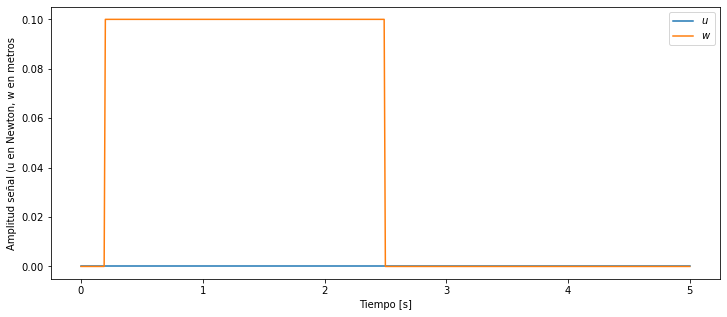

In [5]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(T, U[0,:], label=r'$u$')
ax.plot(T, U[1,:], label=r'$w$')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Amplitud señal (u en Newton, w en metros')
ax.legend();

Ahora simularemos la respuesta al sistema a esas dos entradas.

In [6]:
x0 = (0, 0, 0, 0)
t, y = ctrl.input_output_response(susp_sys, T, U, x0)

En $y$ y en $t$ ahora están los valores que toman la salida $y(t) = x_1(t)-x_2(t)$, para distintos valores de $t$.

## Práctico 1

1. Hacer un diagrama del bloque de la suspensión donde se vean cuales son las entradas y las salidas. De las entradas diferenciar cuales son perturbaciones y cuales son variables manipuladas.
1. Viendo la grafica de las entradas anterior, analizar:
    - que fénomino físico se está evaluando si $w$ tiene la forma mostrada en la figura anterior
    - que significa que la señal $u$ sea siempre cero
1. Graficar la salida $y$ obtenida de la simulación del sistema. Analizar la respuesta. ¿Será confortable el viaje en un bus con esa supensión?

Ayuda: 
- Utilizar como referencia el código de las gráficas de $U$ para hacer la gráfica de $y$
- con `y.shape` y `t.shape` obtenemos la "forma" de la señal. Por ejemplo, al señal $U$ de la figura anterior tiene `(2, 501)`, es decir, 2 filas (una para $u$ y otra para $w$) y 501 columnas (una para cada instante simulado).
- para hacer el diagrama de bloques usar como referencia el apunte de introducción a señales y sistemas.
